In [1]:
! pip install optuna  scikit-learn gensim imbalanced-learn xgboost torch pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.5 MB/s eta 0:00:00


In [1]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report

import numpy as np
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import mean_squared_error
import optuna
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import time
from collections import Counter
# PyTorch Import

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import DataParallel

WINDOW_SIZE = 50

# 1 - One Hot Encoding with Pytorch in build Emnedding
# 2 - 3-mer coding with number encoding
ENCODING_METHOD = 2

# 1- Random Over Sampling
# 2 - Weighted Over Sampler
SAMPLING_METHOD =1

# 1 - LSTM with Cross Entropy
MODEL = 1


FRAMEWORK = "PYTORCH"

# Startegy to Crop Sequene
# MID - Modification is present at Mid of cropped Sequence
# END - Modification is present at End of cropepd Sequence
CROP_STRATEGY = 'MID'

# Y Category Encoding Method
# LABEL or ONE_HOT
TARGET_ENCODING = 'LABEL'

ENCODING_FILE = '3-mer-dictionary.pkl'

In [2]:

# from google.colab import drive
# drive.mount('/content/drive')
# INPUT_TRAIN_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/train_in.csv"
# INPUT_TRAIN_OUT = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/train_out.csv"
# INPUT_TEST_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/test_in.csv"
# INPUT_TEST_OUT = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/test_out.csv"
# INPUT_VALIDATION_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/valid_in_nucleo.csv"
# INPUT_VALIDATION_OUT  = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/valid_out.csv"

# Record Constants
# Record Constants
INPUT_TRAIN_IN = "train_in.csv"
INPUT_TRAIN_OUT = "train_out.csv"
INPUT_TEST_IN = "test_in.csv"
INPUT_TEST_OUT = "test_out.csv"
INPUT_VALIDATION_IN = "valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "valid_out.csv"

# TARGET_MODEL_PATH = '../../webapp/model_files'




In [3]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1 )
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1 )
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1 )

x_data = pd.concat([x_train_raw, x_test_raw, x_valid_raw], axis=0, ignore_index=True)
y_data = pd.concat([y_train_raw, y_test_raw, y_valid_raw], axis=0, ignore_index=True)

print(f"Train Shape of X : {x_train_raw.shape} and Tranin Shape of Y : {x_train_raw.shape}")
print(f"Test Shape of X : {x_test_raw.shape} and Test Shape of Y : {y_test_raw.shape}")
print(f"Validation Shape of X : {x_valid_raw.shape} and Validation Shape of Y : {y_valid_raw.shape}")


Train Shape of X : (304661, 1001) and Tranin Shape of Y : (304661, 1001)
Test Shape of X : (1200, 1001) and Test Shape of Y : (1200, 12)
Validation Shape of X : (3599, 1001) and Validation Shape of Y : (3599, 12)


### Calculate Sequence Positions to extracted from Original Sequence

In [4]:
middle_index = (x_train_raw.shape[1] // 2) + 1 # This is location for Modified Sequence . Use this as Y Target

if CROP_STRATEGY == 'MID':
    STRAT_INEDX =middle_index - WINDOW_SIZE -1
    END_INDEX =middle_index + WINDOW_SIZE

if CROP_STRATEGY == 'END':
    STRAT_INEDX =middle_index - (WINDOW_SIZE*2) -1
    END_INDEX =middle_index

x_data_cropped =  x_data.iloc[:,STRAT_INEDX :END_INDEX]
concatenated_column= x_data_cropped.apply(lambda row: ''.join(map(str, row)), axis=1)
x_data_cropped = x_data_cropped.assign(Sequence=concatenated_column)

In [6]:
x_data_cropped

,450,451,452,453,454,455,456,457,458,459,...,542,543,544,545,546,547,548,549,550,Sequence
0,T,T,G,C,C,A,C,A,C,T,...,C,A,G,T,A,T,C,T,C,TTGCCACACTGCTGGACGCCTGCAAGGCCAAGGGTACGGAGGTCAT...
1,T,T,T,G,A,A,A,A,A,A,...,T,C,A,T,C,G,T,G,C,TTTGAAAAAATATTAGCAATGTGAGGACACTTAAGCAGTTTTGTCA...
2,A,G,A,A,A,C,A,T,T,C,...,T,T,C,T,G,T,T,C,A,AGAAACATTCAACCTCCCTTCTTTTTATTCCAGTTGTCCTTTTCTC...
3,T,T,A,G,T,T,T,T,A,C,...,A,A,A,A,A,T,T,T,C,TTAGTTTTACTATGGAATCATAATAACCCACATAGAAGACTGATAT...
4,C,A,A,C,A,G,A,A,G,T,...,A,A,A,A,T,G,T,A,C,CAACAGAAGTTTCTCATCTATAATCAGTAGCACTAAACTCTTGGTT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309455,C,C,A,A,A,C,T,C,T,T,...,G,G,G,C,A,G,A,G,A,CCAAACTCTTTATCTCTTGAGTTCTCAGCCAATAGGGCCATTGTAG...
309456,G,A,T,C,C,A,G,T,T,G,...,A,C,A,G,G,T,A,A,T,GATCCAGTTGAAAACGTATCCCTCTACTTTCTTCAGTTGTAGAAAA...
309457,G,C,C,A,G,G,G,C,A,A,...,C,A,A,G,C,T,G,A,T,GCCAGGGCAAAGCTGGCTGATTTTACGTGTTTAAGGATGAAATATC...
309458,C,T,G,G,G,T,G,C,G,A,...,G,C,A,G,A,G,T,C,A,CTGGGTGCGACAGGCCACTGGACAAGGGCTTGAGTGGATGGGATGG...


In [5]:
x_train_raw = None
y_train_raw = None
x_test_raw = None
y_test_raw = None
x_valid_raw = None
y_valid_raw = None

### Apply One Hot Encoding

In [6]:
number_of_unique_kmers = set()
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    number_of_unique_kmers.add(kmer_token)
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

def applyOneHotEncoding(tokenized_sequences):
    encoded_sequences = []
    for seq in tokenized_sequences:
        encoded_sequences.append(encode_seq(seq))

    return np.array(encoded_sequences).flatten()

def encode_with_one_hot_encoding(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    concatenated_column= truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    df_result = truncated_df.assign(Sequence=concatenated_column)
    tokenized_sequences =  df_result['Sequence'].apply(applyOneHotEncoding).tolist()

    return tokenized_sequences


### 3 mer coding

In [7]:
import pickle

kmer_dict = {}
k = 3
with open(ENCODING_FILE, 'rb') as f:
    kmer_dict = pickle.load(f)


def encode_with_k_mer_codon(sequence):
    #print(sequence)
    encoded_sequence = []
    for i in range(len(sequence) - k + 1):
        if sequence[i:i+k] not in kmer_dict:
            print("Key Not Found" , kmer_dict)
        encoded_sequence.append(kmer_dict[sequence[i:i+k]] )
    return np.array(encoded_sequence)

In [8]:
## Filter Dataset to Keep only Target Binary Class

RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]

eligible_class_list = ['hTm', 'hm5U', 'hPsi']
ARMEncoding = [0,1,2]

def convert_y_to_original_labels(row):
    label = ""  
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            label = RMs[index]
    if label == '':
        return 'NonMoD'
    return label

def get_original_y_lables( y_data ):
    # Convert One Hot Encoded Y to to Original Labels
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    return y_original_labels



def encode_target(y_data):
    # Write Customer Lable Encoder . This is required since we have train and test alreday splitted. Always creating a new instanc of label encoder will change encoding.

    y_encoded = []
    for y in y_data:
        index = eligible_class_list.index(y)
        encoding =  ARMEncoding[index]
        y_encoded.append(encoding)
    return y_encoded

def prepare_data_for_binary_classification(x_data , y_data , prediction_class):
    # Convert One Hot Encoded Y to to Original Labels
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    x_data['Label'] = y_original_labels

    selected_rna_data = x_data[x_data['Label'].isin(prediction_class)]

    y_filtered = selected_rna_data['Label']
    x_filtered = selected_rna_data.drop('Label', axis=1)

    return x_filtered , y_filtered

### Filter Data For target Class

In [9]:

x_data_filtered , y_data_filtered = prepare_data_for_binary_classification(x_data_cropped , y_data , eligible_class_list)


In [10]:
x_data_filtered

,450,451,452,453,454,455,456,457,458,459,...,542,543,544,545,546,547,548,549,550,Sequence
8680,C,T,T,A,A,A,A,G,A,A,...,A,T,G,T,G,G,C,C,C,CTTAAAAGAAGTGCTAAGATGGTGCTGAAGTTCATAATCCAAACGT...
8681,T,C,A,T,C,T,G,T,A,T,...,T,T,T,T,T,T,T,T,T,TCATCTGTATTGTAGCATGTGTCAGGCCTTCATTTGTTTTTATGGC...
8682,T,T,G,T,T,T,C,C,T,G,...,G,G,A,G,G,G,T,T,T,TTGTTTCCTGATGATACGGCTTCTCCAGAGTTTGGGGGGCCTGGAA...
8683,A,G,A,G,T,A,T,A,A,T,...,C,A,G,T,G,A,A,C,T,AGAGTATAATTAGAAGACTCTTCTGAACAGAGAATTTTAAGTGGGA...
8684,G,C,C,C,T,G,T,G,C,C,...,G,C,A,T,T,T,C,T,T,GCCCTGTGCCTGGTAACGATCGTTCTCACAGTCATGGCCGTAGGGA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309006,A,A,T,T,A,A,A,A,C,A,...,C,A,G,C,T,T,C,A,A,AATTAAAACAAGTGTTTTAAGATTTCACAGATATCTAAATACAGCA...
309007,G,A,G,A,T,C,T,G,C,C,...,G,T,A,T,C,T,T,A,A,GAGATCTGCCCGCCTCAGCCTCCCAAAGTGCTCGGATTATAGGCGT...
309008,T,A,T,A,C,T,A,A,C,A,...,G,C,C,A,T,T,T,G,T,TATACTAACAAGTGTGAGATGCTAACTCATGGTTTTATTTTGCATT...
309009,A,T,A,C,A,G,T,T,A,T,...,T,C,A,C,C,C,A,G,A,ATACAGTTATGTCAGTAGTGTAAGGTTACGTACATTACAGTAGTGT...


In [11]:
y_data_filtered.value_counts()

Label
hm5U    3696
hPsi    3137
hTm     2253
Name: count, dtype: int64

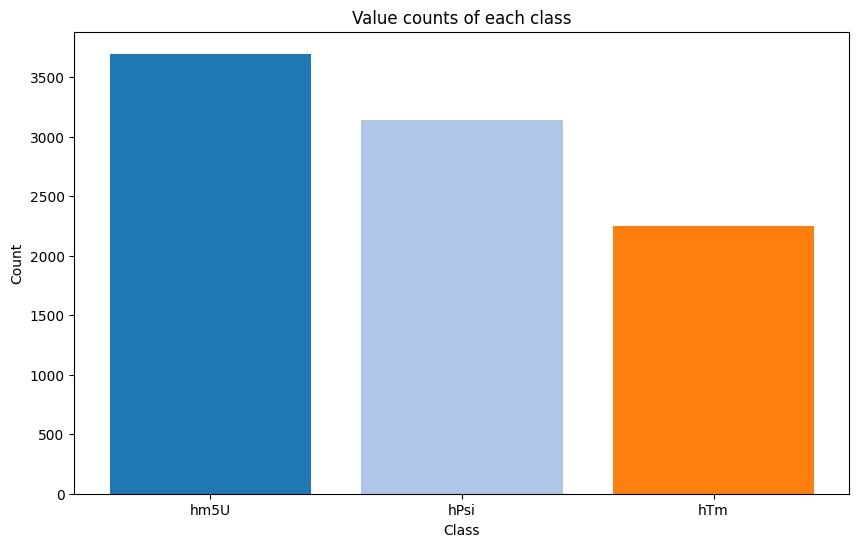

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

y_counts = y_data_filtered.value_counts()
colors = cm.tab20(range(len(y_counts)))
plt.figure(figsize=(10, 6))
plt.bar(y_counts.index, y_counts.values , color = colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Value counts of each class')
plt.show()

In [15]:
x_data_filtered['Sequence']

8680      CTTAAAAGAAGTGCTAAGATGGTGCTGAAGTTCATAATCCAAACGT...
8681      TCATCTGTATTGTAGCATGTGTCAGGCCTTCATTTGTTTTTATGGC...
8682      TTGTTTCCTGATGATACGGCTTCTCCAGAGTTTGGGGGGCCTGGAA...
8683      AGAGTATAATTAGAAGACTCTTCTGAACAGAGAATTTTAAGTGGGA...
8684      GCCCTGTGCCTGGTAACGATCGTTCTCACAGTCATGGCCGTAGGGA...
                                ...                        
309006    AATTAAAACAAGTGTTTTAAGATTTCACAGATATCTAAATACAGCA...
309007    GAGATCTGCCCGCCTCAGCCTCCCAAAGTGCTCGGATTATAGGCGT...
309008    TATACTAACAAGTGTGAGATGCTAACTCATGGTTTTATTTTGCATT...
309009    ATACAGTTATGTCAGTAGTGTAAGGTTACGTACATTACAGTAGTGT...
309010    GTGAACTGCTTTAGGACAGATTCAGTTCTGTGATCAAGATGAAAAA...
Name: Sequence, Length: 9086, dtype: object

In [13]:
encoded_sequences = [encode_with_k_mer_codon(sequence) for sequence in x_data_filtered['Sequence']]
X_encoded = np.array(encoded_sequences)
X_encoded_tensor = torch.tensor(X_encoded, dtype=torch.float32)
y_encoded = encode_target(y_data_filtered)

In [14]:
X_encoded_tensor

tensor([[42., 62., 47.,  ..., 17., 29.,  0.],
        [11.,  2., 12.,  ..., 50., 50., 50.],
        [35., 26., 34.,  ..., 21., 34., 50.],
        ...,
        [32.,  3.,  4.,  ..., 50., 35., 26.],
        [ 3.,  4., 37.,  ...,  1., 19., 56.],
        [27., 52., 53.,  ..., 40., 51., 57.]])

In [15]:
print("Generate Train and Split..")
# Train set
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# Test and Validation set
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Generate Train and Split..


In [16]:
X_encoded = None
y_encoded = None
x_data_filtered , y_data_filtered = None,None
x_data , y_data = None , None

print("Train Y Count : " ,Counter(y_train))
print("Test Y Count : " ,Counter(y_test))


Train Y Count :  Counter({1: 2594, 2: 2196, 0: 1570})
Test Y Count :  Counter({1: 532, 2: 500, 0: 331})


### Balance Datset

In [17]:
y_train = torch.tensor(y_train , dtype=torch.long)
y_test = torch.tensor(y_test , dtype=torch.long)
y_valid = torch.tensor(y_valid , dtype=torch.long)

sm = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled = torch.tensor(y_resampled , dtype=torch.float32) # Keeping float32
X_resampled = torch.tensor(X_resampled , dtype=torch.float32)

In [18]:
print(X_train.shape)
print(y_train.shape)

(6360, 99)
torch.Size([6360])


In [19]:
X_resampled[1]

tensor([26., 46., 32.,  3.,  4., 37.,  2.,  3., 32., 12., 13.,  0.,  0.,  0.,
        23., 38., 53., 48., 56., 53., 54., 12., 13.,  1., 19., 56., 39.,  9.,
        46., 32.,  3., 32., 12., 15., 38., 53., 63., 54., 12., 11., 19.,  9.,
        27., 45., 21., 34., 50., 43., 22., 42., 62., 32.,  3., 47., 63., 63.,
        54., 61., 62., 47., 63., 59., 37.,  2.,  3., 32., 61., 43., 22., 42.,
        62.,  4.,  5.,  1.,  2., 33., 28., 18., 19.,  9., 34., 43., 11., 19.,
        31., 18., 60., 54., 12., 11., 36., 37.,  2., 12., 13.,  6., 42., 35.,
        45.])

In [62]:
hyperparameter = {}
hyperparameter['INPUT_DIMENSION'] = len(kmer_dict) # For One Hot Encoding Input Dimension would be 4 as there only 4 unique nucleocide
hyperparameter['HIDDEN_DIMENSION'] = 32
hyperparameter['NO_OF_LAYERS'] = 2
hyperparameter['BATCH_SIZE'] = 512
hyperparameter['OUTPUT_DIMENSION'] = len(eligible_class_list)
hyperparameter['EMBEDDING_DIMENSION'] = 8 # if you are using Word2Vec Encoding then this should be same as Word2Vec Embedding Dim
hyperparameter['DROP_OUT'] = 0.30705959993626625
hyperparameter['LEARNING_RATE'] = 0.0005256027052154265

train_losses = []
val_losses = []
val_accuracies = []
    
class RNADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = RNADataset(X_resampled, y_resampled)
test_dataset = RNADataset(X_test, y_test)
valid_dataset = RNADataset(X_valid, y_valid)


train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

### Model Architecure

In [26]:
import torch.nn as nn

class RNATransformerModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers, output_dim, dropout):
        super(RNATransformerModel, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # If batch size first is true then it should be batch size , sequence lenght , embedding dimension
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=2, dim_feedforward=hidden_dim , batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        #print("Shape of Original X  ", x.shape)
        x_embedded = self.embedding(x)
        #print("Shape of X embedded" , x_embedded.shape)
        x_transformed = self.transformer_encoder(x_embedded)
        #print("Shape of Transformed X" , x_transformed.shape)
        x_transformed = x_transformed[:, -1, :]  # taking the last token's output

        output = self.dropout(x_transformed)
        out = self.fc(output)
        return out

In [22]:
# Check data is in correct shape - batch size , sequece len , embedding dimension size
for inputs, labels in train_dataloader:
    print(inputs.shape)
    break

torch.Size([64, 99])


### Train and Validate

In [43]:
import torch.optim.lr_scheduler as lr_scheduler


def validate_model(model, test_dataloader , device ,loss_function):
    model.eval()
    running_loss = 0.0
    class_correct = [0] * hyperparameter['OUTPUT_DIMENSION']
    class_total = [0] * hyperparameter['OUTPUT_DIMENSION']
    total = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.inference_mode():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())  # Capture True Lables for Summary Report
            predicted_labels.extend(predicted.cpu().numpy()) # Capture Predicted Labels Lables for Summary Report

    validation_loss = running_loss / len(test_dataloader)
    validation_accuracy = correct / total

    return validation_loss , validation_accuracy , true_labels , predicted_labels


def train_model(model, train_dataloader, test_dataloader, device, epochs, optimizer, loss_function):
    best_val_loss = float('inf')
    no_improvement_count = 0
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        val_loss,  validation_accuracy , true_labels , predicted_labels = validate_model(model, test_dataloader, device, loss_function)
        end_time = time.time()
        elapsed_time = end_time - start_time

        if epoch % 5 == 0:
            print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {validation_accuracy:.4f} ,Learning Rate: {optimizer.param_groups[0]['lr']} , Time Taken : {elapsed_time}")
        
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        val_accuracies.append(validation_accuracy)
        
        #scheduler.step()

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             no_improvement_count = 0
#         else:
#             no_improvement_count += 1
#             if no_improvement_count == 20:
#                 print("No improvement in validation loss for 5 epochs. Training stopped.")
#                 break



### Run

In [63]:
model = RNATransformerModel(input_dim=hyperparameter['INPUT_DIMENSION'],
                            embedding_dim=hyperparameter['EMBEDDING_DIMENSION'],
                            hidden_dim=hyperparameter['HIDDEN_DIMENSION'] ,
                            num_layers = hyperparameter['NO_OF_LAYERS'],
                            output_dim=hyperparameter['OUTPUT_DIMENSION'],
                            dropout=hyperparameter['DROP_OUT'] )


loss_function = nn.CrossEntropyLoss()  ## MSELoss of Regression problem  # BCELoss for binary classification
optimizer = optim.Adam(model.parameters() ,  lr=hyperparameter['LEARNING_RATE'])

train_losses = []
val_losses = []
val_accuracies = []

# Number of Parameters for Model
total_parameters = []
for p in model.parameters():
    total_parameters.append(p.numel())

print(f"Total Number of Parameters for Model Training : { sum(total_parameters)} " )

# Train the model
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DataParallel(model)
model = model.to(device)

print("Model Parameters  : " , hyperparameter)

# Train Model with configured Parameter
train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_function)

Total Number of Parameters for Model Training : 3395 
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 32, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 8, 'DROP_OUT': 0.30705959993626625, 'LEARNING_RATE': 0.0005256027052154265}
Epoch 1, Train Loss: 1.2601, Val Loss: 1.1857, Test Accuracy: 0.3368 ,Learning Rate: 0.0005256027052154265 , Time Taken : 0.7544329166412354
Epoch 6, Train Loss: 1.1376, Val Loss: 1.1122, Test Accuracy: 0.3287 ,Learning Rate: 0.0005256027052154265 , Time Taken : 0.7619426250457764
Epoch 11, Train Loss: 1.1151, Val Loss: 1.1005, Test Accuracy: 0.3448 ,Learning Rate: 0.0005256027052154265 , Time Taken : 0.735332727432251
Epoch 16, Train Loss: 1.1079, Val Loss: 1.0988, Test Accuracy: 0.3448 ,Learning Rate: 0.0005256027052154265 , Time Taken : 0.7512128353118896
Epoch 21, Train Loss: 1.1063, Val Loss: 1.0990, Test Accuracy: 0.3492 ,Learning Rate: 0.0005256027052154265 , Time Taken : 0.6649124622344971
Epoch 26, 

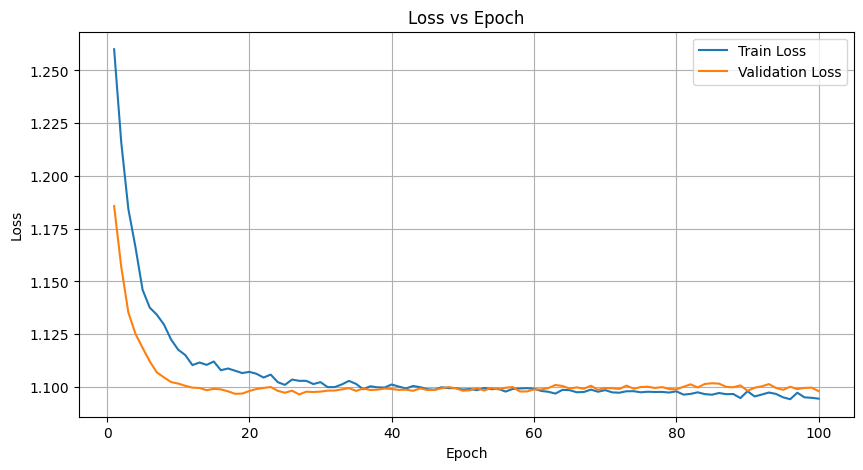

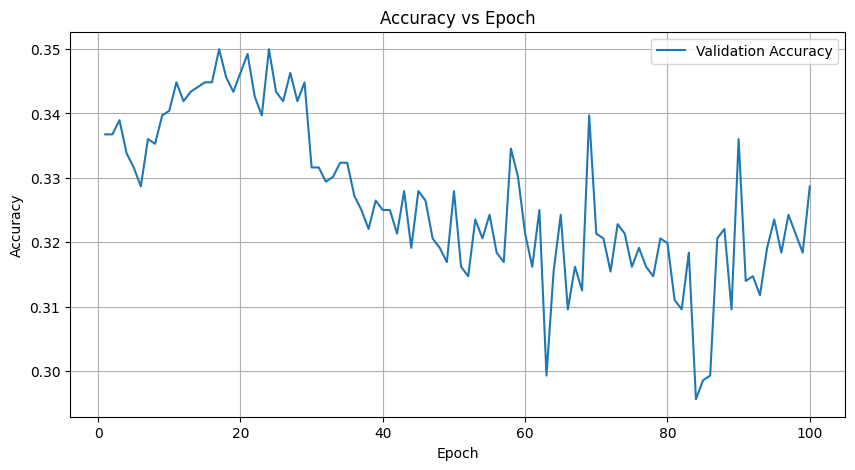

In [65]:
import matplotlib.pyplot as plt


# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


### Optuna Hyperparameter Optimization

In [46]:
import optuna

def objective(trial):
    hyperparameter = {}
    hyperparameter['INPUT_DIMENSION'] = len(kmer_dict)
    hyperparameter['HIDDEN_DIMENSION'] = trial.suggest_categorical('HIDDEN_DIMENSION', [64, 512, 1024])
    hyperparameter['NO_OF_LAYERS'] = trial.suggest_int('NO_OF_LAYERS', 1, 4)
    hyperparameter['BATCH_SIZE'] =  trial.suggest_categorical('BATCH_SIZE', [64, 512, 1024])
    hyperparameter['OUTPUT_DIMENSION'] = len(eligible_class_list)
    hyperparameter['EMBEDDING_DIMENSION'] = trial.suggest_categorical('EMBEDDING_DIMENSION', [1024, 256, 32])  # Adjust as needed
    hyperparameter['DROP_OUT'] = trial.suggest_float('DROP_OUT', 0.1, 0.5)
    hyperparameter['LEARNING_RATE'] = trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-3)

    model = RNATransformerModel(input_dim=hyperparameter['INPUT_DIMENSION'],
                                embedding_dim=hyperparameter['EMBEDDING_DIMENSION'],
                                hidden_dim=hyperparameter['HIDDEN_DIMENSION'],
                                num_layers=hyperparameter['NO_OF_LAYERS'],
                                output_dim=hyperparameter['OUTPUT_DIMENSION'],
                                dropout=hyperparameter['DROP_OUT'])

    model = DataParallel(model)
    model = model.to(device)

    num_epochs = 30
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparameter['LEARNING_RATE'])

    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

    print("Model Parameters  : " , hyperparameter)
    
    train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_function)

    _, final_accuracy, true_labels, predicted_labels = validate_model(model, valid_dataloader,device,loss_function)

    return final_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

    # Print the result
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-15 03:44:55,407] A new study created in memory with name: no-name-a1ec359b-22d2-4a79-8699-96d2d0675d04
/tmp/ipykernel_393/228537490.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  hyperparameter['LEARNING_RATE'] = trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-3)


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.41970874486528953, 'LEARNING_RATE': 0.0005543296159807417}
Epoch 1, Train Loss: 1.1926, Val Loss: 1.1324, Test Accuracy: 0.3434 ,Learning Rate: 0.0005543296159807417 , Time Taken : 4.756785869598389
Epoch 6, Train Loss: 1.0513, Val Loss: 1.1085, Test Accuracy: 0.3514 ,Learning Rate: 0.0005543296159807417 , Time Taken : 4.943722724914551
Epoch 11, Train Loss: 1.0134, Val Loss: 1.1353, Test Accuracy: 0.3712 ,Learning Rate: 0.0005543296159807417 , Time Taken : 4.992568492889404
Epoch 16, Train Loss: 0.9693, Val Loss: 1.1878, Test Accuracy: 0.3478 ,Learning Rate: 0.0005543296159807417 , Time Taken : 4.718478441238403
Epoch 21, Train Loss: 0.9377, Val Loss: 1.2262, Test Accuracy: 0.3221 ,Learning Rate: 0.0005543296159807417 , Time Taken : 5.304853200912476
Epoch 26, Train Loss: 0.9081, Val Loss: 1.2947, Test Accuracy: 0.34

[I 2023-08-15 03:47:29,201] Trial 0 finished with value: 0.3690388848129127 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.41970874486528953, 'LEARNING_RATE': 0.0005543296159807417}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.22450044734217572, 'LEARNING_RATE': 0.00020026796366357752}
Epoch 1, Train Loss: 1.1928, Val Loss: 1.1289, Test Accuracy: 0.3125 ,Learning Rate: 0.00020026796366357752 , Time Taken : 0.9531691074371338
Epoch 6, Train Loss: 1.1078, Val Loss: 1.1015, Test Accuracy: 0.3265 ,Learning Rate: 0.00020026796366357752 , Time Taken : 0.9546129703521729
Epoch 11, Train Loss: 1.1021, Val Loss: 1.0956, Test Accuracy: 0.3463 ,Learning Rate: 0.00020026796366357752 , Time Taken : 0.9582045078277588
Epoch 16, Train Loss: 1.0982, Val Loss: 1.1027, Test Accuracy: 0.3265 ,Learning Rate: 0.00020026796366357752 , Time Taken : 0.9506359100341797
Epoch 21, Train Loss: 1.0955, Val Loss: 1.1058, Test Accuracy: 0.3236 ,Learning Rate: 0.00020026796366357752 , Time Taken : 0.955488920211792
Epoch 26, Train Loss: 1.0910, Val Loss: 1.1036, Test Acc

[I 2023-08-15 03:47:57,908] Trial 1 finished with value: 0.3675715333822451 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.22450044734217572, 'LEARNING_RATE': 0.00020026796366357752}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.23351823174123143, 'LEARNING_RATE': 2.0122999552307556e-05}
Epoch 1, Train Loss: 1.1839, Val Loss: 1.1267, Test Accuracy: 0.3331 ,Learning Rate: 2.0122999552307556e-05 , Time Taken : 7.468768358230591
Epoch 6, Train Loss: 1.1018, Val Loss: 1.1267, Test Accuracy: 0.3272 ,Learning Rate: 2.0122999552307556e-05 , Time Taken : 7.621894598007202
Epoch 11, Train Loss: 1.0620, Val Loss: 1.1268, Test Accuracy: 0.3507 ,Learning Rate: 2.0122999552307556e-05 , Time Taken : 7.758696556091309
Epoch 16, Train Loss: 1.0240, Val Loss: 1.1403, Test Accuracy: 0.3852 ,Learning Rate: 2.0122999552307556e-05 , Time Taken : 7.7701520919799805
Epoch 21, Train Loss: 0.9701, Val Loss: 1.1840, Test Accuracy: 0.3822 ,Learning Rate: 2.0122999552307556e-05 , Time Taken : 7.9254374504089355
Epoch 26, Train Loss: 0.9211, Val Loss: 1.2378, Test Ac

[I 2023-08-15 03:51:52,825] Trial 2 finished with value: 0.3573000733675715 and parameters: {'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.23351823174123143, 'LEARNING_RATE': 2.0122999552307556e-05}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.2171706318754613, 'LEARNING_RATE': 1.5219093995114673e-05}
Epoch 1, Train Loss: 1.1766, Val Loss: 1.1155, Test Accuracy: 0.3639 ,Learning Rate: 1.5219093995114673e-05 , Time Taken : 7.726532459259033
Epoch 6, Train Loss: 1.1128, Val Loss: 1.1038, Test Accuracy: 0.3558 ,Learning Rate: 1.5219093995114673e-05 , Time Taken : 7.855345726013184
Epoch 11, Train Loss: 1.0932, Val Loss: 1.1046, Test Accuracy: 0.3456 ,Learning Rate: 1.5219093995114673e-05 , Time Taken : 7.893215894699097
Epoch 16, Train Loss: 1.0676, Val Loss: 1.1148, Test Accuracy: 0.3426 ,Learning Rate: 1.5219093995114673e-05 , Time Taken : 7.9615397453308105
Epoch 21, Train Loss: 1.0454, Val Loss: 1.1366, Test Accuracy: 0.3382 ,Learning Rate: 1.5219093995114673e-05 , Time Taken : 8.214241027832031
Epoch 26, Train Loss: 1.0070, Val Loss: 1.1512, Test Accur

[I 2023-08-15 03:55:54,156] Trial 3 finished with value: 0.3492296404988995 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.2171706318754613, 'LEARNING_RATE': 1.5219093995114673e-05}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.1981984034470591, 'LEARNING_RATE': 0.00014957013691946786}
Epoch 1, Train Loss: 1.1617, Val Loss: 1.1058, Test Accuracy: 0.3522 ,Learning Rate: 0.00014957013691946786 , Time Taken : 1.3993415832519531
Epoch 6, Train Loss: 1.0905, Val Loss: 1.1250, Test Accuracy: 0.3302 ,Learning Rate: 0.00014957013691946786 , Time Taken : 1.3937859535217285
Epoch 11, Train Loss: 1.0504, Val Loss: 1.1232, Test Accuracy: 0.3646 ,Learning Rate: 0.00014957013691946786 , Time Taken : 1.3890156745910645
Epoch 16, Train Loss: 1.0041, Val Loss: 1.1352, Test Accuracy: 0.3844 ,Learning Rate: 0.00014957013691946786 , Time Taken : 1.3791859149932861
Epoch 21, Train Loss: 0.9445, Val Loss: 1.2145, Test Accuracy: 0.3771 ,Learning Rate: 0.00014957013691946786 , Time Taken : 1.3791828155517578
Epoch 26, Train Loss: 0.8819, Val Loss: 1.2870, Test Ac

[I 2023-08-15 03:56:35,677] Trial 4 finished with value: 0.338958180484226 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.1981984034470591, 'LEARNING_RATE': 0.00014957013691946786}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.1607671408079262, 'LEARNING_RATE': 5.0442535368643924e-05}
Epoch 1, Train Loss: 1.2516, Val Loss: 1.2490, Test Accuracy: 0.3118 ,Learning Rate: 5.0442535368643924e-05 , Time Taken : 0.511181116104126
Epoch 6, Train Loss: 1.2096, Val Loss: 1.2067, Test Accuracy: 0.3206 ,Learning Rate: 5.0442535368643924e-05 , Time Taken : 0.6070563793182373
Epoch 11, Train Loss: 1.1872, Val Loss: 1.1792, Test Accuracy: 0.3184 ,Learning Rate: 5.0442535368643924e-05 , Time Taken : 0.5715579986572266
Epoch 16, Train Loss: 1.1616, Val Loss: 1.1601, Test Accuracy: 0.3206 ,Learning Rate: 5.0442535368643924e-05 , Time Taken : 0.5729527473449707
Epoch 21, Train Loss: 1.1497, Val Loss: 1.1470, Test Accuracy: 0.3228 ,Learning Rate: 5.0442535368643924e-05 , Time Taken : 0.5843830108642578
Epoch 26, Train Loss: 1.1415, Val Loss: 1.1375, Test Accur

[I 2023-08-15 03:56:53,201] Trial 5 finished with value: 0.31988261188554656 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.1607671408079262, 'LEARNING_RATE': 5.0442535368643924e-05}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.3029447490300309, 'LEARNING_RATE': 5.64612578888314e-05}
Epoch 1, Train Loss: 1.2409, Val Loss: 1.1472, Test Accuracy: 0.3896 ,Learning Rate: 5.64612578888314e-05 , Time Taken : 0.5904090404510498
Epoch 6, Train Loss: 1.1803, Val Loss: 1.1392, Test Accuracy: 0.3346 ,Learning Rate: 5.64612578888314e-05 , Time Taken : 0.6132407188415527
Epoch 11, Train Loss: 1.1622, Val Loss: 1.1256, Test Accuracy: 0.3250 ,Learning Rate: 5.64612578888314e-05 , Time Taken : 0.6251342296600342
Epoch 16, Train Loss: 1.1443, Val Loss: 1.1159, Test Accuracy: 0.3243 ,Learning Rate: 5.64612578888314e-05 , Time Taken : 0.7676103115081787
Epoch 21, Train Loss: 1.1420, Val Loss: 1.1104, Test Accuracy: 0.3287 ,Learning Rate: 5.64612578888314e-05 , Time Taken : 0.6260755062103271
Epoch 26, Train Loss: 1.1331, Val Loss: 1.1073, Test Accuracy: 0.324

[I 2023-08-15 03:57:12,469] Trial 6 finished with value: 0.32134996331621424 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.3029447490300309, 'LEARNING_RATE': 5.64612578888314e-05}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.17738696694528483, 'LEARNING_RATE': 0.00012427914792975501}
Epoch 1, Train Loss: 1.2594, Val Loss: 1.1386, Test Accuracy: 0.3683 ,Learning Rate: 0.00012427914792975501 , Time Taken : 7.726549863815308
Epoch 6, Train Loss: 1.0454, Val Loss: 1.1275, Test Accuracy: 0.3514 ,Learning Rate: 0.00012427914792975501 , Time Taken : 7.814918518066406
Epoch 11, Train Loss: 0.9004, Val Loss: 1.2433, Test Accuracy: 0.3690 ,Learning Rate: 0.00012427914792975501 , Time Taken : 8.005754470825195
Epoch 16, Train Loss: 0.7412, Val Loss: 1.4294, Test Accuracy: 0.3786 ,Learning Rate: 0.00012427914792975501 , Time Taken : 7.959141969680786
Epoch 21, Train Loss: 0.5478, Val Loss: 1.8228, Test Accuracy: 0.3588 ,Learning Rate: 0.00012427914792975501 , Time Taken : 8.214470386505127
Epoch 26, Train Loss: 0.3917, Val Loss: 2.2800, Test Accur

[I 2023-08-15 04:01:14,573] Trial 7 finished with value: 0.3360234776228907 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.17738696694528483, 'LEARNING_RATE': 0.00012427914792975501}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.24193012572888067, 'LEARNING_RATE': 0.00010347343140990092}
Epoch 1, Train Loss: 1.2329, Val Loss: 1.1741, Test Accuracy: 0.3463 ,Learning Rate: 0.00010347343140990092 , Time Taken : 0.3487725257873535
Epoch 6, Train Loss: 1.1419, Val Loss: 1.1205, Test Accuracy: 0.3463 ,Learning Rate: 0.00010347343140990092 , Time Taken : 0.3740105628967285
Epoch 11, Train Loss: 1.1227, Val Loss: 1.1079, Test Accuracy: 0.3375 ,Learning Rate: 0.00010347343140990092 , Time Taken : 0.374281644821167
Epoch 16, Train Loss: 1.1083, Val Loss: 1.1055, Test Accuracy: 0.3397 ,Learning Rate: 0.00010347343140990092 , Time Taken : 0.37598633766174316
Epoch 21, Train Loss: 1.1059, Val Loss: 1.1034, Test Accuracy: 0.3382 ,Learning Rate: 0.00010347343140990092 , Time Taken : 0.37718987464904785
Epoch 26, Train Loss: 1.1022, Val Loss: 1.1023, Test

[I 2023-08-15 04:01:26,110] Trial 8 finished with value: 0.34849596478356565 and parameters: {'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.24193012572888067, 'LEARNING_RATE': 0.00010347343140990092}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.49956164253822, 'LEARNING_RATE': 2.0314687238175214e-05}
Epoch 1, Train Loss: 1.2208, Val Loss: 1.1222, Test Accuracy: 0.3456 ,Learning Rate: 2.0314687238175214e-05 , Time Taken : 14.157058477401733
Epoch 6, Train Loss: 1.0985, Val Loss: 1.1077, Test Accuracy: 0.3639 ,Learning Rate: 2.0314687238175214e-05 , Time Taken : 14.178347826004028
Epoch 11, Train Loss: 0.9975, Val Loss: 1.1783, Test Accuracy: 0.3412 ,Learning Rate: 2.0314687238175214e-05 , Time Taken : 14.045075178146362
Epoch 16, Train Loss: 0.8786, Val Loss: 1.3066, Test Accuracy: 0.3654 ,Learning Rate: 2.0314687238175214e-05 , Time Taken : 14.177493572235107
Epoch 21, Train Loss: 0.7395, Val Loss: 1.4806, Test Accuracy: 0.3764 ,Learning Rate: 2.0314687238175214e-05 , Time Taken : 14.193609476089478
Epoch 26, Train Loss: 0.5897, Val Loss: 1.8588, Test Accu

[I 2023-08-15 04:08:29,588] Trial 9 finished with value: 0.34849596478356565 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.49956164253822, 'LEARNING_RATE': 2.0314687238175214e-05}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.41138177101083284, 'LEARNING_RATE': 0.0008687318794511172}
Epoch 1, Train Loss: 1.1602, Val Loss: 1.1062, Test Accuracy: 0.3661 ,Learning Rate: 0.0008687318794511172 , Time Taken : 5.1150994300842285
Epoch 6, Train Loss: 1.0919, Val Loss: 1.0931, Test Accuracy: 0.3602 ,Learning Rate: 0.0008687318794511172 , Time Taken : 5.2472100257873535
Epoch 11, Train Loss: 1.0852, Val Loss: 1.1047, Test Accuracy: 0.3595 ,Learning Rate: 0.0008687318794511172 , Time Taken : 5.309288024902344
Epoch 16, Train Loss: 1.0926, Val Loss: 1.1127, Test Accuracy: 0.3199 ,Learning Rate: 0.0008687318794511172 , Time Taken : 5.283399343490601
Epoch 21, Train Loss: 1.0911, Val Loss: 1.1122, Test Accuracy: 0.3646 ,Learning Rate: 0.0008687318794511172 , Time Taken : 5.29113507270813
Epoch 26, Train Loss: 1.0946, Val Loss: 1.0892, Test Accuracy: 0.3

[I 2023-08-15 04:11:07,018] Trial 10 finished with value: 0.31254585473220836 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.41138177101083284, 'LEARNING_RATE': 0.0008687318794511172}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3324349139354693, 'LEARNING_RATE': 0.0004199674869820215}
Epoch 1, Train Loss: 1.1682, Val Loss: 1.1096, Test Accuracy: 0.3133 ,Learning Rate: 0.0004199674869820215 , Time Taken : 5.031499624252319
Epoch 6, Train Loss: 1.0648, Val Loss: 1.1172, Test Accuracy: 0.3624 ,Learning Rate: 0.0004199674869820215 , Time Taken : 5.200265169143677
Epoch 11, Train Loss: 1.0263, Val Loss: 1.1143, Test Accuracy: 0.3676 ,Learning Rate: 0.0004199674869820215 , Time Taken : 5.0433549880981445
Epoch 16, Train Loss: 0.9952, Val Loss: 1.1637, Test Accuracy: 0.3492 ,Learning Rate: 0.0004199674869820215 , Time Taken : 5.204493761062622
Epoch 21, Train Loss: 0.9676, Val Loss: 1.1697, Test Accuracy: 0.3764 ,Learning Rate: 0.0004199674869820215 , Time Taken : 4.9632837772369385
Epoch 26, Train Loss: 0.9257, Val Loss: 1.1932, Test Accuracy: 0.

[I 2023-08-15 04:13:40,290] Trial 11 finished with value: 0.3499633162142333 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3324349139354693, 'LEARNING_RATE': 0.0004199674869820215}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.12209320529269593, 'LEARNING_RATE': 0.0003122308200899167}
Epoch 1, Train Loss: 1.1746, Val Loss: 1.1307, Test Accuracy: 0.3103 ,Learning Rate: 0.0003122308200899167 , Time Taken : 0.6994891166687012
Epoch 6, Train Loss: 1.1024, Val Loss: 1.1109, Test Accuracy: 0.2905 ,Learning Rate: 0.0003122308200899167 , Time Taken : 0.6975746154785156
Epoch 11, Train Loss: 1.0996, Val Loss: 1.1083, Test Accuracy: 0.3221 ,Learning Rate: 0.0003122308200899167 , Time Taken : 0.693333625793457
Epoch 16, Train Loss: 1.0915, Val Loss: 1.1058, Test Accuracy: 0.3309 ,Learning Rate: 0.0003122308200899167 , Time Taken : 0.8636243343353271
Epoch 21, Train Loss: 1.0867, Val Loss: 1.1028, Test Accuracy: 0.3360 ,Learning Rate: 0.0003122308200899167 , Time Taken : 0.7865650653839111
Epoch 26, Train Loss: 1.0807, Val Loss: 1.0998, Test Accuracy:

[I 2023-08-15 04:14:02,782] Trial 12 finished with value: 0.3330887747615554 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.12209320529269593, 'LEARNING_RATE': 0.0003122308200899167}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.34547730983633584, 'LEARNING_RATE': 0.0008312551386096382}
Epoch 1, Train Loss: 1.1529, Val Loss: 1.0982, Test Accuracy: 0.3441 ,Learning Rate: 0.0008312551386096382 , Time Taken : 6.288177728652954
Epoch 6, Train Loss: 1.0909, Val Loss: 1.1218, Test Accuracy: 0.3243 ,Learning Rate: 0.0008312551386096382 , Time Taken : 5.994645595550537
Epoch 11, Train Loss: 1.1024, Val Loss: 1.1058, Test Accuracy: 0.3008 ,Learning Rate: 0.0008312551386096382 , Time Taken : 6.494215488433838
Epoch 16, Train Loss: 1.1013, Val Loss: 1.0918, Test Accuracy: 0.3903 ,Learning Rate: 0.0008312551386096382 , Time Taken : 6.184739112854004
Epoch 21, Train Loss: 1.1001, Val Loss: 1.1078, Test Accuracy: 0.2861 ,Learning Rate: 0.0008312551386096382 , Time Taken : 6.321737051010132
Epoch 26, Train Loss: 1.1005, Val Loss: 1.0878, Test Accuracy: 0.3

[I 2023-08-15 04:17:12,900] Trial 13 finished with value: 0.3235509904622157 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.34547730983633584, 'LEARNING_RATE': 0.0008312551386096382}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.3983113621750464, 'LEARNING_RATE': 0.00028281083567983743}
Epoch 1, Train Loss: 1.1739, Val Loss: 1.1116, Test Accuracy: 0.3287 ,Learning Rate: 0.00028281083567983743 , Time Taken : 0.8208441734313965
Epoch 6, Train Loss: 1.0995, Val Loss: 1.1043, Test Accuracy: 0.3338 ,Learning Rate: 0.00028281083567983743 , Time Taken : 0.8103764057159424
Epoch 11, Train Loss: 1.0975, Val Loss: 1.1006, Test Accuracy: 0.3397 ,Learning Rate: 0.00028281083567983743 , Time Taken : 0.8189725875854492
Epoch 16, Train Loss: 1.0919, Val Loss: 1.1083, Test Accuracy: 0.3103 ,Learning Rate: 0.00028281083567983743 , Time Taken : 0.8154313564300537
Epoch 21, Train Loss: 1.0900, Val Loss: 1.1105, Test Accuracy: 0.3199 ,Learning Rate: 0.00028281083567983743 , Time Taken : 0.815802812576294
Epoch 26, Train Loss: 1.0878, Val Loss: 1.1123, Test Acc

[I 2023-08-15 04:17:37,586] Trial 14 finished with value: 0.3374908290535583 and parameters: {'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.3983113621750464, 'LEARNING_RATE': 0.00028281083567983743}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2661271924007254, 'LEARNING_RATE': 0.0004530725160045504}
Epoch 1, Train Loss: 1.1458, Val Loss: 1.0793, Test Accuracy: 0.3793 ,Learning Rate: 0.0004530725160045504 , Time Taken : 5.519159555435181
Epoch 6, Train Loss: 1.0484, Val Loss: 1.1578, Test Accuracy: 0.3463 ,Learning Rate: 0.0004530725160045504 , Time Taken : 6.396773338317871
Epoch 11, Train Loss: 0.9996, Val Loss: 1.1707, Test Accuracy: 0.3162 ,Learning Rate: 0.0004530725160045504 , Time Taken : 6.381722927093506
Epoch 16, Train Loss: 0.9351, Val Loss: 1.2143, Test Accuracy: 0.3632 ,Learning Rate: 0.0004530725160045504 , Time Taken : 6.384241580963135
Epoch 21, Train Loss: 0.8835, Val Loss: 1.3023, Test Accuracy: 0.3815 ,Learning Rate: 0.0004530725160045504 , Time Taken : 6.434907913208008
Epoch 26, Train Loss: 0.8240, Val Loss: 1.2804, Test Accuracy: 0.366

[I 2023-08-15 04:20:45,819] Trial 15 finished with value: 0.3690388848129127 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2661271924007254, 'LEARNING_RATE': 0.0004530725160045504}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2724642639819643, 'LEARNING_RATE': 0.00045673128429187616}
Epoch 1, Train Loss: 1.1580, Val Loss: 1.1104, Test Accuracy: 0.3434 ,Learning Rate: 0.00045673128429187616 , Time Taken : 3.4448111057281494
Epoch 6, Train Loss: 1.0487, Val Loss: 1.1597, Test Accuracy: 0.3294 ,Learning Rate: 0.00045673128429187616 , Time Taken : 3.4897093772888184
Epoch 11, Train Loss: 0.9981, Val Loss: 1.1643, Test Accuracy: 0.3331 ,Learning Rate: 0.00045673128429187616 , Time Taken : 3.664062261581421
Epoch 16, Train Loss: 0.9729, Val Loss: 1.1661, Test Accuracy: 0.3566 ,Learning Rate: 0.00045673128429187616 , Time Taken : 3.6498684883117676
Epoch 21, Train Loss: 0.9466, Val Loss: 1.2100, Test Accuracy: 0.3426 ,Learning Rate: 0.00045673128429187616 , Time Taken : 3.8220388889312744
Epoch 26, Train Loss: 0.9219, Val Loss: 1.2501, Test Accur

[I 2023-08-15 04:22:33,437] Trial 16 finished with value: 0.3374908290535583 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2724642639819643, 'LEARNING_RATE': 0.00045673128429187616}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2933355175769046, 'LEARNING_RATE': 0.0005575314362398862}
Epoch 1, Train Loss: 1.1632, Val Loss: 1.1241, Test Accuracy: 0.3287 ,Learning Rate: 0.0005575314362398862 , Time Taken : 5.197420120239258
Epoch 6, Train Loss: 1.0482, Val Loss: 1.1133, Test Accuracy: 0.3668 ,Learning Rate: 0.0005575314362398862 , Time Taken : 5.344378232955933
Epoch 11, Train Loss: 1.0003, Val Loss: 1.1470, Test Accuracy: 0.3764 ,Learning Rate: 0.0005575314362398862 , Time Taken : 5.453591346740723
Epoch 16, Train Loss: 0.9642, Val Loss: 1.1718, Test Accuracy: 0.3507 ,Learning Rate: 0.0005575314362398862 , Time Taken : 5.267174005508423
Epoch 21, Train Loss: 0.9313, Val Loss: 1.2348, Test Accuracy: 0.3434 ,Learning Rate: 0.0005575314362398862 , Time Taken : 5.277703523635864
Epoch 26, Train Loss: 0.8785, Val Loss: 1.2668, Test Accuracy: 0.356

[I 2023-08-15 04:25:09,052] Trial 17 finished with value: 0.3661041819515774 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2933355175769046, 'LEARNING_RATE': 0.0005575314362398862}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.40160250535364805, 'LEARNING_RATE': 0.0006571443090465291}
Epoch 1, Train Loss: 1.1611, Val Loss: 1.0898, Test Accuracy: 0.3837 ,Learning Rate: 0.0006571443090465291 , Time Taken : 6.290011882781982
Epoch 6, Train Loss: 1.0829, Val Loss: 1.1288, Test Accuracy: 0.3448 ,Learning Rate: 0.0006571443090465291 , Time Taken : 6.376063585281372
Epoch 11, Train Loss: 1.0811, Val Loss: 1.0987, Test Accuracy: 0.3470 ,Learning Rate: 0.0006571443090465291 , Time Taken : 6.429545640945435
Epoch 16, Train Loss: 1.0969, Val Loss: 1.1017, Test Accuracy: 0.3595 ,Learning Rate: 0.0006571443090465291 , Time Taken : 5.76538610458374
Epoch 21, Train Loss: 1.0987, Val Loss: 1.1031, Test Accuracy: 0.3184 ,Learning Rate: 0.0006571443090465291 , Time Taken : 6.419498443603516
Epoch 26, Train Loss: 1.0991, Val Loss: 1.0886, Test Accuracy: 0.362

[I 2023-08-15 04:28:14,772] Trial 18 finished with value: 0.260454878943507 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.40160250535364805, 'LEARNING_RATE': 0.0006571443090465291}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.4925893236059491, 'LEARNING_RATE': 0.0009718361717636657}
Epoch 1, Train Loss: 1.1772, Val Loss: 1.0983, Test Accuracy: 0.3507 ,Learning Rate: 0.0009718361717636657 , Time Taken : 5.215850114822388
Epoch 6, Train Loss: 1.0853, Val Loss: 1.1045, Test Accuracy: 0.3720 ,Learning Rate: 0.0009718361717636657 , Time Taken : 5.28130578994751
Epoch 11, Train Loss: 1.0890, Val Loss: 1.1098, Test Accuracy: 0.3544 ,Learning Rate: 0.0009718361717636657 , Time Taken : 4.908169269561768
Epoch 16, Train Loss: 1.0895, Val Loss: 1.1028, Test Accuracy: 0.3661 ,Learning Rate: 0.0009718361717636657 , Time Taken : 5.246263265609741
Epoch 21, Train Loss: 1.0958, Val Loss: 1.0951, Test Accuracy: 0.3558 ,Learning Rate: 0.0009718361717636657 , Time Taken : 5.039264917373657
Epoch 26, Train Loss: 1.0939, Val Loss: 1.0901, Test Accuracy: 0.3749

[I 2023-08-15 04:30:50,021] Trial 19 finished with value: 0.34556126192223036 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.4925893236059491, 'LEARNING_RATE': 0.0009718361717636657}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2625137540159267, 'LEARNING_RATE': 0.0002742147842306929}
Epoch 1, Train Loss: 1.1532, Val Loss: 1.0939, Test Accuracy: 0.3800 ,Learning Rate: 0.0002742147842306929 , Time Taken : 6.028625965118408
Epoch 6, Train Loss: 1.0428, Val Loss: 1.1201, Test Accuracy: 0.3566 ,Learning Rate: 0.0002742147842306929 , Time Taken : 6.562991619110107
Epoch 11, Train Loss: 0.9285, Val Loss: 1.2033, Test Accuracy: 0.3698 ,Learning Rate: 0.0002742147842306929 , Time Taken : 6.323838949203491
Epoch 16, Train Loss: 0.7837, Val Loss: 1.3672, Test Accuracy: 0.3632 ,Learning Rate: 0.0002742147842306929 , Time Taken : 6.411180257797241
Epoch 21, Train Loss: 0.6622, Val Loss: 1.5114, Test Accuracy: 0.3705 ,Learning Rate: 0.0002742147842306929 , Time Taken : 5.9960596561431885
Epoch 26, Train Loss: 0.5631, Val Loss: 1.6695, Test Accuracy: 0.37

[I 2023-08-15 04:34:01,144] Trial 20 finished with value: 0.3374908290535583 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2625137540159267, 'LEARNING_RATE': 0.0002742147842306929}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.20377525485664, 'LEARNING_RATE': 0.00020180458000602648}
Epoch 1, Train Loss: 1.1803, Val Loss: 1.1078, Test Accuracy: 0.3507 ,Learning Rate: 0.00020180458000602648 , Time Taken : 0.9818177223205566
Epoch 6, Train Loss: 1.1068, Val Loss: 1.0941, Test Accuracy: 0.3749 ,Learning Rate: 0.00020180458000602648 , Time Taken : 0.9815177917480469
Epoch 11, Train Loss: 1.0995, Val Loss: 1.1004, Test Accuracy: 0.3404 ,Learning Rate: 0.00020180458000602648 , Time Taken : 0.9364943504333496
Epoch 16, Train Loss: 1.0948, Val Loss: 1.1037, Test Accuracy: 0.3250 ,Learning Rate: 0.00020180458000602648 , Time Taken : 0.9786841869354248
Epoch 21, Train Loss: 1.0930, Val Loss: 1.1021, Test Accuracy: 0.3338 ,Learning Rate: 0.00020180458000602648 , Time Taken : 0.9783635139465332
Epoch 26, Train Loss: 1.0930, Val Loss: 1.1066, Test Accur

[I 2023-08-15 04:34:30,867] Trial 21 finished with value: 0.338958180484226 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.20377525485664, 'LEARNING_RATE': 0.00020180458000602648}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.24664277296179135, 'LEARNING_RATE': 0.00048588975153127936}
Epoch 1, Train Loss: 1.1493, Val Loss: 1.1516, Test Accuracy: 0.2436 ,Learning Rate: 0.00048588975153127936 , Time Taken : 6.1669020652771
Epoch 6, Train Loss: 1.0693, Val Loss: 1.1197, Test Accuracy: 0.3059 ,Learning Rate: 0.00048588975153127936 , Time Taken : 6.103157997131348
Epoch 11, Train Loss: 1.0516, Val Loss: 1.0972, Test Accuracy: 0.3500 ,Learning Rate: 0.00048588975153127936 , Time Taken : 6.012093544006348
Epoch 16, Train Loss: 1.0453, Val Loss: 1.1705, Test Accuracy: 0.3199 ,Learning Rate: 0.00048588975153127936 , Time Taken : 6.331404447555542
Epoch 21, Train Loss: 1.0425, Val Loss: 1.1606, Test Accuracy: 0.3272 ,Learning Rate: 0.00048588975153127936 , Time Taken : 6.553695917129517
Epoch 26, Train Loss: 1.0374, Val Loss: 1.1650, Test Accuracy:

[I 2023-08-15 04:37:33,255] Trial 22 finished with value: 0.3418928833455613 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.24664277296179135, 'LEARNING_RATE': 0.00048588975153127936}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.10507011323813883, 'LEARNING_RATE': 0.00019928799212043914}
Epoch 1, Train Loss: 1.1429, Val Loss: 1.0910, Test Accuracy: 0.3683 ,Learning Rate: 0.00019928799212043914 , Time Taken : 0.976402759552002
Epoch 6, Train Loss: 1.1008, Val Loss: 1.1028, Test Accuracy: 0.3177 ,Learning Rate: 0.00019928799212043914 , Time Taken : 0.97318434715271
Epoch 11, Train Loss: 1.0916, Val Loss: 1.0979, Test Accuracy: 0.3507 ,Learning Rate: 0.00019928799212043914 , Time Taken : 0.8993964195251465
Epoch 16, Train Loss: 1.0898, Val Loss: 1.0947, Test Accuracy: 0.3573 ,Learning Rate: 0.00019928799212043914 , Time Taken : 0.9015560150146484
Epoch 21, Train Loss: 1.0831, Val Loss: 1.1018, Test Accuracy: 0.3536 ,Learning Rate: 0.00019928799212043914 , Time Taken : 0.9693858623504639
Epoch 26, Train Loss: 1.0793, Val Loss: 1.1077, Test Accu

[I 2023-08-15 04:38:02,416] Trial 23 finished with value: 0.32868672046955244 and parameters: {'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.10507011323813883, 'LEARNING_RATE': 0.00019928799212043914}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2922529015652981, 'LEARNING_RATE': 0.0003956330699463656}
Epoch 1, Train Loss: 1.1642, Val Loss: 1.1183, Test Accuracy: 0.3485 ,Learning Rate: 0.0003956330699463656 , Time Taken : 4.638720512390137
Epoch 6, Train Loss: 1.0465, Val Loss: 1.1373, Test Accuracy: 0.3558 ,Learning Rate: 0.0003956330699463656 , Time Taken : 5.282916784286499
Epoch 11, Train Loss: 0.9633, Val Loss: 1.1849, Test Accuracy: 0.3536 ,Learning Rate: 0.0003956330699463656 , Time Taken : 4.853830575942993
Epoch 16, Train Loss: 0.8957, Val Loss: 1.2418, Test Accuracy: 0.3551 ,Learning Rate: 0.0003956330699463656 , Time Taken : 4.7116618156433105
Epoch 21, Train Loss: 0.8142, Val Loss: 1.3306, Test Accuracy: 0.3727 ,Learning Rate: 0.0003956330699463656 , Time Taken : 4.961007118225098
Epoch 26, Train Loss: 0.7509, Val Loss: 1.4227, Test Accuracy: 0.37

[I 2023-08-15 04:40:35,067] Trial 24 finished with value: 0.3294203961848863 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2922529015652981, 'LEARNING_RATE': 0.0003956330699463656}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.15799399130747785, 'LEARNING_RATE': 0.0003498041643010087}
Epoch 1, Train Loss: 1.1582, Val Loss: 1.1153, Test Accuracy: 0.3294 ,Learning Rate: 0.0003498041643010087 , Time Taken : 0.9455621242523193
Epoch 6, Train Loss: 1.1022, Val Loss: 1.0942, Test Accuracy: 0.3668 ,Learning Rate: 0.0003498041643010087 , Time Taken : 0.8702507019042969
Epoch 11, Train Loss: 1.0914, Val Loss: 1.1041, Test Accuracy: 0.3419 ,Learning Rate: 0.0003498041643010087 , Time Taken : 0.9632806777954102
Epoch 16, Train Loss: 1.0907, Val Loss: 1.1122, Test Accuracy: 0.3236 ,Learning Rate: 0.0003498041643010087 , Time Taken : 0.8637795448303223
Epoch 21, Train Loss: 1.0843, Val Loss: 1.0944, Test Accuracy: 0.3764 ,Learning Rate: 0.0003498041643010087 , Time Taken : 0.8720362186431885
Epoch 26, Train Loss: 1.0805, Val Loss: 1.1049, Test Accuracy

[I 2023-08-15 04:41:02,658] Trial 25 finished with value: 0.3206162876008804 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.15799399130747785, 'LEARNING_RATE': 0.0003498041643010087}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.33706317643386036, 'LEARNING_RATE': 0.000698787265797787}
Epoch 1, Train Loss: 1.1496, Val Loss: 1.1152, Test Accuracy: 0.2810 ,Learning Rate: 0.000698787265797787 , Time Taken : 7.455140829086304
Epoch 6, Train Loss: 1.0941, Val Loss: 1.0900, Test Accuracy: 0.3558 ,Learning Rate: 0.000698787265797787 , Time Taken : 7.484065294265747
Epoch 11, Train Loss: 1.0984, Val Loss: 1.0906, Test Accuracy: 0.3727 ,Learning Rate: 0.000698787265797787 , Time Taken : 7.711540937423706
Epoch 16, Train Loss: 1.1021, Val Loss: 1.1155, Test Accuracy: 0.2428 ,Learning Rate: 0.000698787265797787 , Time Taken : 6.9150168895721436
Epoch 21, Train Loss: 1.1012, Val Loss: 1.1018, Test Accuracy: 0.3654 ,Learning Rate: 0.000698787265797787 , Time Taken : 7.4978392124176025
Epoch 26, Train Loss: 1.0998, Val Loss: 1.0976, Test Accuracy: 0.3844 ,

[I 2023-08-15 04:44:46,323] Trial 26 finished with value: 0.3235509904622157 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.33706317643386036, 'LEARNING_RATE': 0.000698787265797787}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2240863352417747, 'LEARNING_RATE': 0.0005429239001798853}
Epoch 1, Train Loss: 1.1468, Val Loss: 1.1156, Test Accuracy: 0.3375 ,Learning Rate: 0.0005429239001798853 , Time Taken : 5.3025853633880615
Epoch 6, Train Loss: 1.0485, Val Loss: 1.1249, Test Accuracy: 0.3610 ,Learning Rate: 0.0005429239001798853 , Time Taken : 5.25653076171875
Epoch 11, Train Loss: 0.9940, Val Loss: 1.1412, Test Accuracy: 0.3610 ,Learning Rate: 0.0005429239001798853 , Time Taken : 5.363754987716675
Epoch 16, Train Loss: 0.9337, Val Loss: 1.2304, Test Accuracy: 0.3404 ,Learning Rate: 0.0005429239001798853 , Time Taken : 4.94785737991333
Epoch 21, Train Loss: 0.8831, Val Loss: 1.2318, Test Accuracy: 0.3500 ,Learning Rate: 0.0005429239001798853 , Time Taken : 5.308223485946655
Epoch 26, Train Loss: 0.8144, Val Loss: 1.4477, Test Accuracy: 0.3397

[I 2023-08-15 04:47:26,022] Trial 27 finished with value: 0.32868672046955244 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2240863352417747, 'LEARNING_RATE': 0.0005429239001798853}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.26720079315128975, 'LEARNING_RATE': 0.0002129527649217362}
Epoch 1, Train Loss: 1.1932, Val Loss: 1.2221, Test Accuracy: 0.2722 ,Learning Rate: 0.0002129527649217362 , Time Taken : 2.4653232097625732
Epoch 6, Train Loss: 1.0656, Val Loss: 1.1510, Test Accuracy: 0.3492 ,Learning Rate: 0.0002129527649217362 , Time Taken : 2.5399136543273926
Epoch 11, Train Loss: 1.0029, Val Loss: 1.2073, Test Accuracy: 0.3551 ,Learning Rate: 0.0002129527649217362 , Time Taken : 2.5542960166931152
Epoch 16, Train Loss: 0.9574, Val Loss: 1.2219, Test Accuracy: 0.3536 ,Learning Rate: 0.0002129527649217362 , Time Taken : 2.5979814529418945
Epoch 21, Train Loss: 0.9280, Val Loss: 1.2582, Test Accuracy: 0.3382 ,Learning Rate: 0.0002129527649217362 , Time Taken : 2.5905914306640625
Epoch 26, Train Loss: 0.9021, Val Loss: 1.2751, Test Accu

[I 2023-08-15 04:48:43,492] Trial 28 finished with value: 0.33088774761555395 and parameters: {'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.26720079315128975, 'LEARNING_RATE': 0.0002129527649217362}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.23260453497022687, 'LEARNING_RATE': 0.0006605987189778755}
Epoch 1, Train Loss: 1.1574, Val Loss: 1.0999, Test Accuracy: 0.3529 ,Learning Rate: 0.0006605987189778755 , Time Taken : 0.8736834526062012
Epoch 6, Train Loss: 1.0988, Val Loss: 1.0939, Test Accuracy: 0.3676 ,Learning Rate: 0.0006605987189778755 , Time Taken : 0.964226245880127
Epoch 11, Train Loss: 1.0909, Val Loss: 1.0964, Test Accuracy: 0.3404 ,Learning Rate: 0.0006605987189778755 , Time Taken : 0.8986220359802246
Epoch 16, Train Loss: 1.0844, Val Loss: 1.0937, Test Accuracy: 0.3390 ,Learning Rate: 0.0006605987189778755 , Time Taken : 0.9555339813232422
Epoch 21, Train Loss: 1.0762, Val Loss: 1.1177, Test Accuracy: 0.3258 ,Learning Rate: 0.0006605987189778755 , Time Taken : 0.8448672294616699
Epoch 26, Train Loss: 1.0652, Val Loss: 1.1244, Test Accuracy:

[I 2023-08-15 04:49:11,216] Trial 29 finished with value: 0.3418928833455613 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.23260453497022687, 'LEARNING_RATE': 0.0006605987189778755}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.3685190509024031, 'LEARNING_RATE': 0.00034184376097513445}
Epoch 1, Train Loss: 1.3074, Val Loss: 1.2270, Test Accuracy: 0.3272 ,Learning Rate: 0.00034184376097513445 , Time Taken : 5.144819498062134
Epoch 6, Train Loss: 1.0604, Val Loss: 1.1245, Test Accuracy: 0.3610 ,Learning Rate: 0.00034184376097513445 , Time Taken : 5.157071352005005
Epoch 11, Train Loss: 0.9808, Val Loss: 1.1705, Test Accuracy: 0.3492 ,Learning Rate: 0.00034184376097513445 , Time Taken : 5.216859340667725
Epoch 16, Train Loss: 0.9471, Val Loss: 1.2091, Test Accuracy: 0.3514 ,Learning Rate: 0.00034184376097513445 , Time Taken : 5.264620304107666
Epoch 21, Train Loss: 0.9384, Val Loss: 1.1994, Test Accuracy: 0.3404 ,Learning Rate: 0.00034184376097513445 , Time Taken : 5.281088829040527
Epoch 26, Train Loss: 0.9217, Val Loss: 1.2521, Test Accur

[I 2023-08-15 04:51:49,426] Trial 30 finished with value: 0.34115920763022745 and parameters: {'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.3685190509024031, 'LEARNING_RATE': 0.00034184376097513445}. Best is trial 0 with value: 0.3690388848129127.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.30705959993626625, 'LEARNING_RATE': 0.0005256027052154265}
Epoch 1, Train Loss: 1.1605, Val Loss: 1.1090, Test Accuracy: 0.3470 ,Learning Rate: 0.0005256027052154265 , Time Taken : 4.715500116348267
Epoch 6, Train Loss: 1.0473, Val Loss: 1.1021, Test Accuracy: 0.3727 ,Learning Rate: 0.0005256027052154265 , Time Taken : 5.381813287734985
Epoch 11, Train Loss: 0.9933, Val Loss: 1.2039, Test Accuracy: 0.2971 ,Learning Rate: 0.0005256027052154265 , Time Taken : 5.348315715789795
Epoch 16, Train Loss: 0.9525, Val Loss: 1.1948, Test Accuracy: 0.3514 ,Learning Rate: 0.0005256027052154265 , Time Taken : 5.285343408584595
Epoch 21, Train Loss: 0.9092, Val Loss: 1.2934, Test Accuracy: 0.3639 ,Learning Rate: 0.0005256027052154265 , Time Taken : 5.270127296447754
Epoch 26, Train Loss: 0.8528, Val Loss: 1.2656, Test Accuracy: 0.36

[I 2023-08-15 04:54:23,980] Trial 31 finished with value: 0.3763756419662509 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.30705959993626625, 'LEARNING_RATE': 0.0005256027052154265}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3022820142952556, 'LEARNING_RATE': 0.00048430910268301475}
Epoch 1, Train Loss: 1.1575, Val Loss: 1.1531, Test Accuracy: 0.3206 ,Learning Rate: 0.00048430910268301475 , Time Taken : 4.634148359298706
Epoch 6, Train Loss: 1.0485, Val Loss: 1.1579, Test Accuracy: 0.3228 ,Learning Rate: 0.00048430910268301475 , Time Taken : 5.216716051101685
Epoch 11, Train Loss: 0.9896, Val Loss: 1.1602, Test Accuracy: 0.3470 ,Learning Rate: 0.00048430910268301475 , Time Taken : 4.7016801834106445
Epoch 16, Train Loss: 0.9433, Val Loss: 1.1808, Test Accuracy: 0.3668 ,Learning Rate: 0.00048430910268301475 , Time Taken : 5.312341690063477
Epoch 21, Train Loss: 0.8898, Val Loss: 1.2712, Test Accuracy: 0.3419 ,Learning Rate: 0.00048430910268301475 , Time Taken : 5.287446975708008
Epoch 26, Train Loss: 0.8462, Val Loss: 1.2826, Test Accuracy

[I 2023-08-15 04:56:55,803] Trial 32 finished with value: 0.3521643433602348 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3022820142952556, 'LEARNING_RATE': 0.00048430910268301475}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2167508195923358, 'LEARNING_RATE': 0.0002391069157083508}
Epoch 1, Train Loss: 1.1446, Val Loss: 1.1094, Test Accuracy: 0.3551 ,Learning Rate: 0.0002391069157083508 , Time Taken : 6.427737236022949
Epoch 6, Train Loss: 1.0462, Val Loss: 1.1234, Test Accuracy: 0.3470 ,Learning Rate: 0.0002391069157083508 , Time Taken : 6.450408220291138
Epoch 11, Train Loss: 0.9031, Val Loss: 1.2595, Test Accuracy: 0.3639 ,Learning Rate: 0.0002391069157083508 , Time Taken : 6.429243564605713
Epoch 16, Train Loss: 0.7501, Val Loss: 1.4308, Test Accuracy: 0.3507 ,Learning Rate: 0.0002391069157083508 , Time Taken : 6.41042423248291
Epoch 21, Train Loss: 0.5836, Val Loss: 1.7375, Test Accuracy: 0.3573 ,Learning Rate: 0.0002391069157083508 , Time Taken : 5.722215414047241
Epoch 26, Train Loss: 0.4838, Val Loss: 1.9283, Test Accuracy: 0.3522

[I 2023-08-15 05:00:05,715] Trial 33 finished with value: 0.34849596478356565 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2167508195923358, 'LEARNING_RATE': 0.0002391069157083508}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2502977708282694, 'LEARNING_RATE': 0.0003637218791695798}
Epoch 1, Train Loss: 1.1582, Val Loss: 1.1333, Test Accuracy: 0.3859 ,Learning Rate: 0.0003637218791695798 , Time Taken : 5.771970510482788
Epoch 6, Train Loss: 1.0409, Val Loss: 1.1191, Test Accuracy: 0.3426 ,Learning Rate: 0.0003637218791695798 , Time Taken : 6.541659355163574
Epoch 11, Train Loss: 0.9433, Val Loss: 1.1998, Test Accuracy: 0.3419 ,Learning Rate: 0.0003637218791695798 , Time Taken : 6.60776424407959
Epoch 16, Train Loss: 0.8346, Val Loss: 1.3970, Test Accuracy: 0.3668 ,Learning Rate: 0.0003637218791695798 , Time Taken : 6.168184280395508
Epoch 21, Train Loss: 0.7294, Val Loss: 1.3908, Test Accuracy: 0.3668 ,Learning Rate: 0.0003637218791695798 , Time Taken : 6.3657755851745605
Epoch 26, Train Loss: 0.6326, Val Loss: 1.6369, Test Accuracy: 0.372

[I 2023-08-15 05:03:14,290] Trial 34 finished with value: 0.35803374908290536 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2502977708282694, 'LEARNING_RATE': 0.0003637218791695798}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2796631418607436, 'LEARNING_RATE': 0.00016240704426708196}
Epoch 1, Train Loss: 1.2178, Val Loss: 1.1548, Test Accuracy: 0.3434 ,Learning Rate: 0.00016240704426708196 , Time Taken : 0.39956164360046387
Epoch 6, Train Loss: 1.1221, Val Loss: 1.1156, Test Accuracy: 0.3258 ,Learning Rate: 0.00016240704426708196 , Time Taken : 0.5648727416992188
Epoch 11, Train Loss: 1.0953, Val Loss: 1.1127, Test Accuracy: 0.3338 ,Learning Rate: 0.00016240704426708196 , Time Taken : 0.42617082595825195
Epoch 16, Train Loss: 1.0724, Val Loss: 1.1223, Test Accuracy: 0.3463 ,Learning Rate: 0.00016240704426708196 , Time Taken : 0.4277462959289551
Epoch 21, Train Loss: 1.0552, Val Loss: 1.1408, Test Accuracy: 0.3434 ,Learning Rate: 0.00016240704426708196 , Time Taken : 0.42656779289245605
Epoch 26, Train Loss: 1.0366, Val Loss: 1.1426, Test

[I 2023-08-15 05:03:27,175] Trial 35 finished with value: 0.3492296404988995 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.2796631418607436, 'LEARNING_RATE': 0.00016240704426708196}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.18676272140151542, 'LEARNING_RATE': 0.0006538013880335455}
Epoch 1, Train Loss: 1.2740, Val Loss: 1.1853, Test Accuracy: 0.3199 ,Learning Rate: 0.0006538013880335455 , Time Taken : 3.9259731769561768
Epoch 6, Train Loss: 1.0773, Val Loss: 1.1449, Test Accuracy: 0.3368 ,Learning Rate: 0.0006538013880335455 , Time Taken : 3.8572998046875
Epoch 11, Train Loss: 1.0616, Val Loss: 1.1431, Test Accuracy: 0.3206 ,Learning Rate: 0.0006538013880335455 , Time Taken : 3.875576972961426
Epoch 16, Train Loss: 1.0833, Val Loss: 1.1083, Test Accuracy: 0.3764 ,Learning Rate: 0.0006538013880335455 , Time Taken : 3.8608388900756836
Epoch 21, Train Loss: 1.0751, Val Loss: 1.1173, Test Accuracy: 0.3558 ,Learning Rate: 0.0006538013880335455 , Time Taken : 3.978942632675171
Epoch 26, Train Loss: 1.0783, Val Loss: 1.0957, Test Accuracy: 0.

[I 2023-08-15 05:05:23,815] Trial 36 finished with value: 0.27292736610418195 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.18676272140151542, 'LEARNING_RATE': 0.0006538013880335455}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.3162624735188776, 'LEARNING_RATE': 0.0002617401263343699}
Epoch 1, Train Loss: 1.1926, Val Loss: 1.1138, Test Accuracy: 0.3067 ,Learning Rate: 0.0002617401263343699 , Time Taken : 7.721464395523071
Epoch 6, Train Loss: 1.1012, Val Loss: 1.1000, Test Accuracy: 0.3331 ,Learning Rate: 0.0002617401263343699 , Time Taken : 7.673545837402344
Epoch 11, Train Loss: 1.0949, Val Loss: 1.1022, Test Accuracy: 0.3529 ,Learning Rate: 0.0002617401263343699 , Time Taken : 7.466625928878784
Epoch 16, Train Loss: 1.0864, Val Loss: 1.1138, Test Accuracy: 0.3258 ,Learning Rate: 0.0002617401263343699 , Time Taken : 7.625628709793091
Epoch 21, Train Loss: 1.0758, Val Loss: 1.1209, Test Accuracy: 0.3441 ,Learning Rate: 0.0002617401263343699 , Time Taken : 7.771056175231934
Epoch 26, Train Loss: 1.0630, Val Loss: 1.1055, Test Accuracy: 0.3639

[I 2023-08-15 05:09:15,469] Trial 37 finished with value: 0.31401320616287604 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.3162624735188776, 'LEARNING_RATE': 0.0002617401263343699}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.21140157877236604, 'LEARNING_RATE': 0.00015930258091961566}
Epoch 1, Train Loss: 1.1662, Val Loss: 1.1140, Test Accuracy: 0.3375 ,Learning Rate: 0.00015930258091961566 , Time Taken : 1.097193956375122
Epoch 6, Train Loss: 1.0987, Val Loss: 1.1109, Test Accuracy: 0.3434 ,Learning Rate: 0.00015930258091961566 , Time Taken : 1.0767531394958496
Epoch 11, Train Loss: 1.0834, Val Loss: 1.1092, Test Accuracy: 0.3646 ,Learning Rate: 0.00015930258091961566 , Time Taken : 1.0791003704071045
Epoch 16, Train Loss: 1.0432, Val Loss: 1.1179, Test Accuracy: 0.3588 ,Learning Rate: 0.00015930258091961566 , Time Taken : 1.0874335765838623
Epoch 21, Train Loss: 1.0086, Val Loss: 1.1731, Test Accuracy: 0.3536 ,Learning Rate: 0.00015930258091961566 , Time Taken : 1.0526213645935059
Epoch 26, Train Loss: 0.9502, Val Loss: 1.1880, Test A

[I 2023-08-15 05:09:48,431] Trial 38 finished with value: 0.35509904622157007 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.21140157877236604, 'LEARNING_RATE': 0.00015930258091961566}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.23568213610311847, 'LEARNING_RATE': 0.0004034406252384665}
Epoch 1, Train Loss: 1.1315, Val Loss: 1.1097, Test Accuracy: 0.3177 ,Learning Rate: 0.0004034406252384665 , Time Taken : 7.897775173187256
Epoch 6, Train Loss: 1.0928, Val Loss: 1.0965, Test Accuracy: 0.3588 ,Learning Rate: 0.0004034406252384665 , Time Taken : 7.879472255706787
Epoch 11, Train Loss: 1.0824, Val Loss: 1.0957, Test Accuracy: 0.3485 ,Learning Rate: 0.0004034406252384665 , Time Taken : 7.5994720458984375
Epoch 16, Train Loss: 1.0724, Val Loss: 1.1104, Test Accuracy: 0.3346 ,Learning Rate: 0.0004034406252384665 , Time Taken : 7.87509822845459
Epoch 21, Train Loss: 1.0450, Val Loss: 1.1368, Test Accuracy: 0.3213 ,Learning Rate: 0.0004034406252384665 , Time Taken : 7.820392370223999
Epoch 26, Train Loss: 1.0153, Val Loss: 1.1338, Test Accuracy: 0.361

[I 2023-08-15 05:13:39,526] Trial 39 finished with value: 0.334556126192223 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.23568213610311847, 'LEARNING_RATE': 0.0004034406252384665}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.2814597187103165, 'LEARNING_RATE': 0.0007941273093778218}
Epoch 1, Train Loss: 1.2176, Val Loss: 1.1799, Test Accuracy: 0.3404 ,Learning Rate: 0.0007941273093778218 , Time Taken : 1.9866299629211426
Epoch 6, Train Loss: 1.0980, Val Loss: 1.1201, Test Accuracy: 0.3764 ,Learning Rate: 0.0007941273093778218 , Time Taken : 1.980285406112671
Epoch 11, Train Loss: 1.0792, Val Loss: 1.1266, Test Accuracy: 0.3492 ,Learning Rate: 0.0007941273093778218 , Time Taken : 1.990525245666504
Epoch 16, Train Loss: 1.0705, Val Loss: 1.1154, Test Accuracy: 0.3676 ,Learning Rate: 0.0007941273093778218 , Time Taken : 2.0572385787963867
Epoch 21, Train Loss: 1.0714, Val Loss: 1.1279, Test Accuracy: 0.3903 ,Learning Rate: 0.0007941273093778218 , Time Taken : 2.0807862281799316
Epoch 26, Train Loss: 1.0725, Val Loss: 1.1207, Test Accuracy: 

[I 2023-08-15 05:14:40,961] Trial 40 finished with value: 0.31548055759354365 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 1024, 'DROP_OUT': 0.2814597187103165, 'LEARNING_RATE': 0.0007941273093778218}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3097782565507163, 'LEARNING_RATE': 0.0004858367146340099}
Epoch 1, Train Loss: 1.1579, Val Loss: 1.1076, Test Accuracy: 0.3610 ,Learning Rate: 0.0004858367146340099 , Time Taken : 5.013916969299316
Epoch 6, Train Loss: 1.0529, Val Loss: 1.1448, Test Accuracy: 0.3522 ,Learning Rate: 0.0004858367146340099 , Time Taken : 5.05585503578186
Epoch 11, Train Loss: 0.9927, Val Loss: 1.1723, Test Accuracy: 0.3404 ,Learning Rate: 0.0004858367146340099 , Time Taken : 5.359158754348755
Epoch 16, Train Loss: 0.9343, Val Loss: 1.2801, Test Accuracy: 0.3514 ,Learning Rate: 0.0004858367146340099 , Time Taken : 5.210580110549927
Epoch 21, Train Loss: 0.8956, Val Loss: 1.2270, Test Accuracy: 0.3705 ,Learning Rate: 0.0004858367146340099 , Time Taken : 4.652991533279419
Epoch 26, Train Loss: 0.8291, Val Loss: 1.3241, Test Accuracy: 0.3610

[I 2023-08-15 05:17:12,708] Trial 41 finished with value: 0.34115920763022745 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3097782565507163, 'LEARNING_RATE': 0.0004858367146340099}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.257079691592024, 'LEARNING_RATE': 0.0005270019675816971}
Epoch 1, Train Loss: 1.1533, Val Loss: 1.1337, Test Accuracy: 0.3624 ,Learning Rate: 0.0005270019675816971 , Time Taken : 5.2770607471466064
Epoch 6, Train Loss: 1.0493, Val Loss: 1.1392, Test Accuracy: 0.3375 ,Learning Rate: 0.0005270019675816971 , Time Taken : 5.306779384613037
Epoch 11, Train Loss: 0.9902, Val Loss: 1.1718, Test Accuracy: 0.3368 ,Learning Rate: 0.0005270019675816971 , Time Taken : 5.387757778167725
Epoch 16, Train Loss: 0.9412, Val Loss: 1.2032, Test Accuracy: 0.3602 ,Learning Rate: 0.0005270019675816971 , Time Taken : 5.27357816696167
Epoch 21, Train Loss: 0.9026, Val Loss: 1.2418, Test Accuracy: 0.3573 ,Learning Rate: 0.0005270019675816971 , Time Taken : 5.566235303878784
Epoch 26, Train Loss: 0.8442, Val Loss: 1.2986, Test Accuracy: 0.3478

[I 2023-08-15 05:19:50,666] Trial 42 finished with value: 0.32134996331621424 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.257079691592024, 'LEARNING_RATE': 0.0005270019675816971}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.29220815158562374, 'LEARNING_RATE': 0.0006070273075153683}
Epoch 1, Train Loss: 1.1502, Val Loss: 1.1410, Test Accuracy: 0.2744 ,Learning Rate: 0.0006070273075153683 , Time Taken : 4.531850576400757
Epoch 6, Train Loss: 1.0683, Val Loss: 1.1112, Test Accuracy: 0.3778 ,Learning Rate: 0.0006070273075153683 , Time Taken : 4.674726486206055
Epoch 11, Train Loss: 1.0479, Val Loss: 1.1415, Test Accuracy: 0.3463 ,Learning Rate: 0.0006070273075153683 , Time Taken : 5.518727779388428
Epoch 16, Train Loss: 1.0500, Val Loss: 1.1357, Test Accuracy: 0.3573 ,Learning Rate: 0.0006070273075153683 , Time Taken : 4.7105536460876465
Epoch 21, Train Loss: 1.0406, Val Loss: 1.1447, Test Accuracy: 0.3316 ,Learning Rate: 0.0006070273075153683 , Time Taken : 5.315825462341309
Epoch 26, Train Loss: 1.0373, Val Loss: 1.1786, Test Accuracy: 0.3

[I 2023-08-15 05:22:20,640] Trial 43 finished with value: 0.3360234776228907 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.29220815158562374, 'LEARNING_RATE': 0.0006070273075153683}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3241532171884425, 'LEARNING_RATE': 0.000986343296131072}
Epoch 1, Train Loss: 1.1647, Val Loss: 1.0965, Test Accuracy: 0.3844 ,Learning Rate: 0.000986343296131072 , Time Taken : 4.615560054779053
Epoch 6, Train Loss: 1.0876, Val Loss: 1.0893, Test Accuracy: 0.3874 ,Learning Rate: 0.000986343296131072 , Time Taken : 5.389395236968994
Epoch 11, Train Loss: 1.0839, Val Loss: 1.0949, Test Accuracy: 0.3536 ,Learning Rate: 0.000986343296131072 , Time Taken : 4.688198089599609
Epoch 16, Train Loss: 1.0889, Val Loss: 1.1317, Test Accuracy: 0.2957 ,Learning Rate: 0.000986343296131072 , Time Taken : 5.462998151779175
Epoch 21, Train Loss: 1.0927, Val Loss: 1.0984, Test Accuracy: 0.3412 ,Learning Rate: 0.000986343296131072 , Time Taken : 5.325848579406738
Epoch 26, Train Loss: 1.0940, Val Loss: 1.0969, Test Accuracy: 0.3448 ,Lea

[I 2023-08-15 05:24:52,217] Trial 44 finished with value: 0.31401320616287604 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3241532171884425, 'LEARNING_RATE': 0.000986343296131072}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.35190995131878106, 'LEARNING_RATE': 0.0003186331140181967}
Epoch 1, Train Loss: 1.1697, Val Loss: 1.1631, Test Accuracy: 0.2817 ,Learning Rate: 0.0003186331140181967 , Time Taken : 4.891114950180054
Epoch 6, Train Loss: 1.0595, Val Loss: 1.1155, Test Accuracy: 0.3536 ,Learning Rate: 0.0003186331140181967 , Time Taken : 4.586877822875977
Epoch 11, Train Loss: 0.9917, Val Loss: 1.1438, Test Accuracy: 0.3558 ,Learning Rate: 0.0003186331140181967 , Time Taken : 4.989608287811279
Epoch 16, Train Loss: 0.9239, Val Loss: 1.2352, Test Accuracy: 0.3646 ,Learning Rate: 0.0003186331140181967 , Time Taken : 5.068913459777832
Epoch 21, Train Loss: 0.8566, Val Loss: 1.3121, Test Accuracy: 0.3793 ,Learning Rate: 0.0003186331140181967 , Time Taken : 5.146916627883911
Epoch 26, Train Loss: 0.7849, Val Loss: 1.4458, Test Accuracy: 0.3

[I 2023-08-15 05:27:21,176] Trial 45 finished with value: 0.31988261188554656 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.35190995131878106, 'LEARNING_RATE': 0.0003186331140181967}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3007190823703152, 'LEARNING_RATE': 0.0007645367294447356}
Epoch 1, Train Loss: 1.2004, Val Loss: 1.0854, Test Accuracy: 0.3734 ,Learning Rate: 0.0007645367294447356 , Time Taken : 0.8938648700714111
Epoch 6, Train Loss: 1.0575, Val Loss: 1.1312, Test Accuracy: 0.3338 ,Learning Rate: 0.0007645367294447356 , Time Taken : 0.8735299110412598
Epoch 11, Train Loss: 0.9479, Val Loss: 1.2297, Test Accuracy: 0.3551 ,Learning Rate: 0.0007645367294447356 , Time Taken : 0.8793938159942627
Epoch 16, Train Loss: 0.8036, Val Loss: 1.4163, Test Accuracy: 0.3580 ,Learning Rate: 0.0007645367294447356 , Time Taken : 0.8772473335266113
Epoch 21, Train Loss: 0.6621, Val Loss: 1.5832, Test Accuracy: 0.3683 ,Learning Rate: 0.0007645367294447356 , Time Taken : 0.8757658004760742
Epoch 26, Train Loss: 0.5278, Val Loss: 1.8295, Test Accuracy

[I 2023-08-15 05:27:48,044] Trial 46 finished with value: 0.3448275862068966 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3007190823703152, 'LEARNING_RATE': 0.0007645367294447356}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.2504691717874472, 'LEARNING_RATE': 0.000411203241670174}
Epoch 1, Train Loss: 1.1234, Val Loss: 1.1035, Test Accuracy: 0.3103 ,Learning Rate: 0.000411203241670174 , Time Taken : 5.595170259475708
Epoch 6, Train Loss: 1.0908, Val Loss: 1.1051, Test Accuracy: 0.3199 ,Learning Rate: 0.000411203241670174 , Time Taken : 5.493973255157471
Epoch 11, Train Loss: 1.0753, Val Loss: 1.1205, Test Accuracy: 0.3177 ,Learning Rate: 0.000411203241670174 , Time Taken : 5.524602890014648
Epoch 16, Train Loss: 1.0607, Val Loss: 1.1225, Test Accuracy: 0.3294 ,Learning Rate: 0.000411203241670174 , Time Taken : 5.546515226364136
Epoch 21, Train Loss: 1.0412, Val Loss: 1.1120, Test Accuracy: 0.3683 ,Learning Rate: 0.000411203241670174 , Time Taken : 4.832170248031616
Epoch 26, Train Loss: 1.0196, Val Loss: 1.1404, Test Accuracy: 0.3544 ,Le

[I 2023-08-15 05:30:28,733] Trial 47 finished with value: 0.33969185619955977 and parameters: {'HIDDEN_DIMENSION': 1024, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.2504691717874472, 'LEARNING_RATE': 0.000411203241670174}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.271780448937251, 'LEARNING_RATE': 0.0005473689402371873}
Epoch 1, Train Loss: 1.1575, Val Loss: 1.1135, Test Accuracy: 0.3434 ,Learning Rate: 0.0005473689402371873 , Time Taken : 3.69529128074646
Epoch 6, Train Loss: 1.0584, Val Loss: 1.1251, Test Accuracy: 0.3346 ,Learning Rate: 0.0005473689402371873 , Time Taken : 3.6045637130737305
Epoch 11, Train Loss: 1.0268, Val Loss: 1.1309, Test Accuracy: 0.3595 ,Learning Rate: 0.0005473689402371873 , Time Taken : 3.7841379642486572
Epoch 16, Train Loss: 1.0053, Val Loss: 1.1997, Test Accuracy: 0.3382 ,Learning Rate: 0.0005473689402371873 , Time Taken : 3.4630699157714844
Epoch 21, Train Loss: 0.9895, Val Loss: 1.1663, Test Accuracy: 0.3595 ,Learning Rate: 0.0005473689402371873 , Time Taken : 3.5241286754608154
Epoch 26, Train Loss: 0.9735, Val Loss: 1.2051, Test Accuracy: 0.

[I 2023-08-15 05:32:15,878] Trial 48 finished with value: 0.3367571533382245 and parameters: {'HIDDEN_DIMENSION': 512, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.271780448937251, 'LEARNING_RATE': 0.0005473689402371873}. Best is trial 31 with value: 0.3763756419662509.


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 3, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3191070958017781, 'LEARNING_RATE': 0.00030346068487164255}
Epoch 1, Train Loss: 1.1695, Val Loss: 1.1240, Test Accuracy: 0.3280 ,Learning Rate: 0.00030346068487164255 , Time Taken : 1.0706567764282227
Epoch 6, Train Loss: 1.0807, Val Loss: 1.1080, Test Accuracy: 0.3470 ,Learning Rate: 0.00030346068487164255 , Time Taken : 1.0571751594543457
Epoch 11, Train Loss: 1.0258, Val Loss: 1.1568, Test Accuracy: 0.3507 ,Learning Rate: 0.00030346068487164255 , Time Taken : 1.040602445602417
Epoch 16, Train Loss: 0.9359, Val Loss: 1.2432, Test Accuracy: 0.3485 ,Learning Rate: 0.00030346068487164255 , Time Taken : 1.0523827075958252
Epoch 21, Train Loss: 0.8336, Val Loss: 1.3819, Test Accuracy: 0.3529 ,Learning Rate: 0.00030346068487164255 , Time Taken : 1.1360626220703125
Epoch 26, Train Loss: 0.7344, Val Loss: 1.4717, Test Accu

[I 2023-08-15 05:32:48,548] Trial 49 finished with value: 0.35069699192956716 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.3191070958017781, 'LEARNING_RATE': 0.00030346068487164255}. Best is trial 31 with value: 0.3763756419662509.


Accuracy: 0.3763756419662509
Best hyperparameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 256, 'DROP_OUT': 0.30705959993626625, 'LEARNING_RATE': 0.0005256027052154265}


In [66]:
# Evaluate the model on the test dataset
_, final_accuracy, true_labels, predicted_labels = validate_model(model, valid_dataloader,device,loss_function)

# Print the final accuracy
print(f"Final Accuracy: {final_accuracy:.4f}")

# Print the classification summary
print("\n Classification Summary:")
print(classification_report(true_labels, predicted_labels))

Final Accuracy: 0.3434

 Classification Summary:
              precision    recall  f1-score   support

           0       0.27      0.27      0.27       352
           1       0.46      0.29      0.35       570
           2       0.32      0.47      0.38       441

    accuracy                           0.34      1363
   macro avg       0.35      0.34      0.34      1363
weighted avg       0.37      0.34      0.34      1363



In [67]:
torch.save(model, "multi-class-type-UT.pt")